In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import linear_model
from scipy import stats
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import os

In [153]:
### Check version
import sys
import sklearn
print(sys.version)
!python --version
print("numpy: ", np.__version__)
print("sklearn: ", sklearn.__version__)

3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Python 3.9.13
numpy:  1.21.5
sklearn:  1.0.2


In [154]:
df = pd.read_csv("forestfires.csv")

In [155]:
def rec(m,n,tol):
    if type(m)!='numpy.ndarray':
        m=np.array(m)
    if type(n)!='numpy.ndarray':
        n=np.array(n)
    l=m.size
    percent = 0
    for i in range(l):
        if np.abs(10**m[i]-10**n[i])<=tol:
            percent+=1
    return 100*(percent/l)

In [156]:
# Define the max tolerance limit for REC curve x-axis
# For this problem this represents the absolute value of error in the prediction of the outcome i.e. area burned
tol_max=20

In [157]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [158]:
df.dtypes


X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [159]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


In [160]:
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

The area of the forest fire (target) is skewed towards 0. Thus we are taking log of to reduce it's skewness.

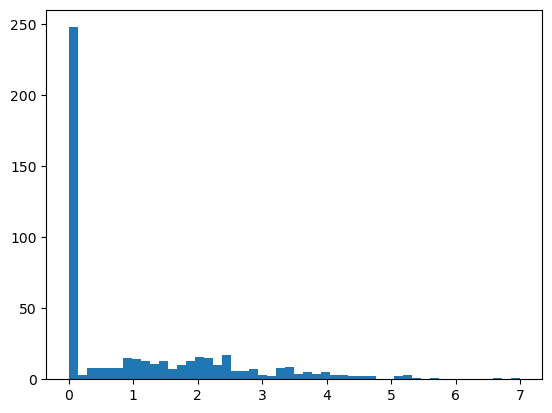

In [161]:
plt.hist(np.log(df['area'] + 1), bins=50)

plt.show()

<BarContainer object of 12 artists>

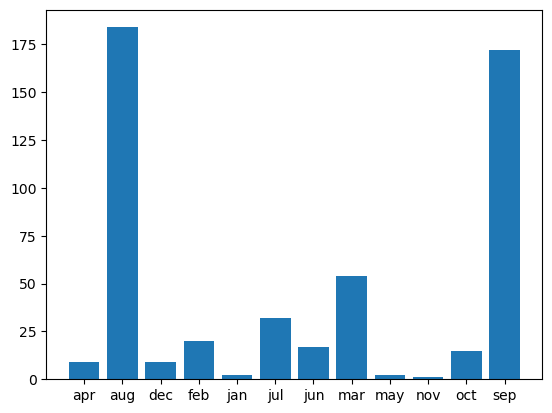

In [162]:
t = df.groupby(['month'])['month'].count()
plt.bar(t.index, t)

(517, 13)
(2017, 13)


<BarContainer object of 12 artists>

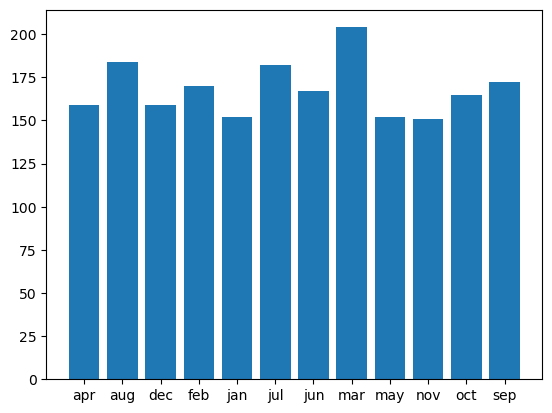

In [163]:
print(df.shape)
for m in df['month'].unique():
    if((m!='aug')&(m!='sep')):
        temp = df[df['month']==m].sample(150, replace=True)
        df = pd.concat([df, temp], axis=0)
#    else:
#        temp = df[df['month']==m].sample(150, replace=True)
#        df = pd.concat([df, temp], axis=0)

print(df.shape)
t = df.groupby(['month'])['month'].count()
plt.bar(t.index, t)

In [164]:
X = df.drop(['area'], axis = 1)
Y = df['area']

In [165]:
# X = pd.get_dummies(X, ['month', 'day'])
enc = LabelEncoder()
enc.fit(df['month'])
X['month_encoded']=enc.transform(X['month'])
enc.fit(X['day'])
X['day_encoded']=enc.transform(X['day'])
X = X.drop(['month', 'day'], axis=1)

In [166]:
X.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,month_encoded,day_encoded
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,7,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,10,5
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,10,2
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,7,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,7,3


In [167]:
x_cols_for_scaling = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']

In [168]:
x_train, x_test, y_train, y_test = train_test_split(X, np.log(Y+1), shuffle=True)
print(x_train.shape, x_test.shape)

(1512, 12) (505, 12)


mse:  1.8238
mae:  1.041
r2:  -0.0179


Text(0, 0.5, 'y_pred')

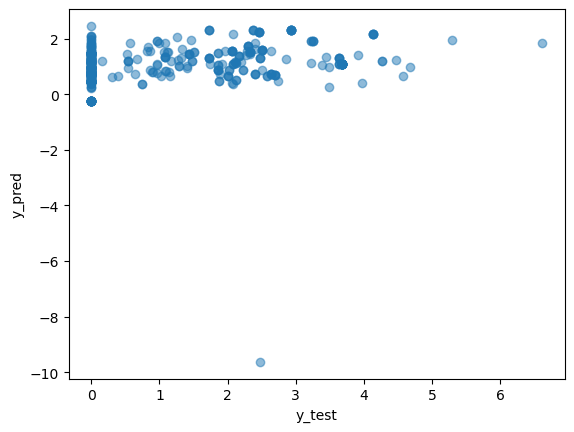

In [169]:
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

# Predict
y_pred = reg.predict(x_test)

# Score
mse = metrics.mean_squared_error(y_test, y_pred)
print('mse: ', np.round(mse, 4))

mae = metrics.mean_absolute_error(y_test, y_pred)
print('mae: ', np.round(mae, 4))

r2 = metrics.r2_score(y_test, y_pred)
print('r2: ', np.round(r2, 4))


# Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')

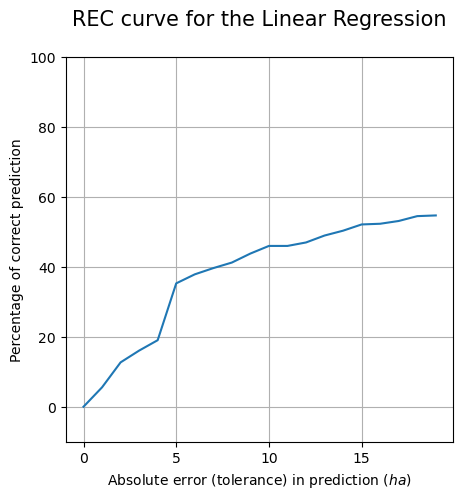

In [170]:
rec_SVR=[]
for i in range(tol_max):
    rec_SVR.append(rec(y_pred,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Linear Regression\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(tol_max+1)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_SVR)

In [171]:
x_train_orig = x_train.loc[:, x_cols_for_scaling]
x_train_cat = x_train.drop(x_cols_for_scaling, axis=1)

x_test_orig = x_test.loc[:, x_train_orig.columns]
x_test_cat = x_test.loc[:, x_train_cat.columns]

In [172]:
scl=preprocessing.StandardScaler()
scl.fit(x_train_orig)

x_train_orig = scl.transform(x_train_orig)
x_test_orig = scl.transform(x_test_orig)

# Combine
x_train = np.concatenate([x_train_orig, np.array(x_train_cat)], axis=1)
x_test = np.concatenate([x_test_orig, np.array(x_test_cat)], axis=1)

print(x_train.shape, x_test.shape)

(1512, 12) (505, 12)


In [173]:
x_train_orig[0]

array([ 1.97521363,  3.73482559, -0.03412521, -0.84154829, -1.08261789,
        0.30566166, -1.11897143,  1.39031013, -0.5540802 , -0.06488604])

mse:  0.3485
mae:  0.2762
r2:  0.8055


Text(0, 0.5, 'y_pred')

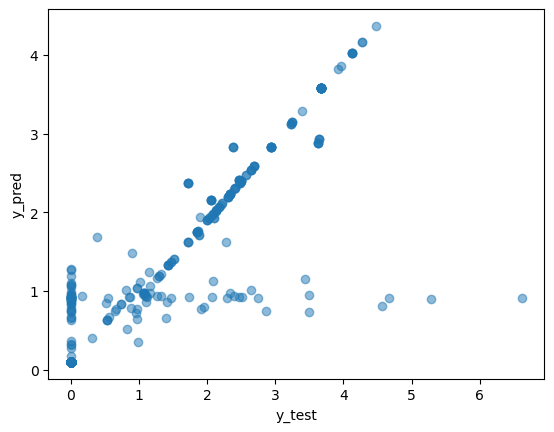

In [174]:
reg = svm.SVR(C=1, kernel='rbf', gamma=1, max_iter=5e4, cache_size=1000, shrinking=False)
reg.fit(x_train, y_train)

# Predict
y_pred = reg.predict(x_test)

# Score
mse = metrics.mean_squared_error(y_test, y_pred)
print('mse: ', np.round(mse, 4))

mae = metrics.mean_absolute_error(y_test, y_pred)
print('mae: ', np.round(mae, 4))

r2 = metrics.r2_score(y_test, y_pred)
print('r2: ', np.round(r2, 4))


# Plot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')


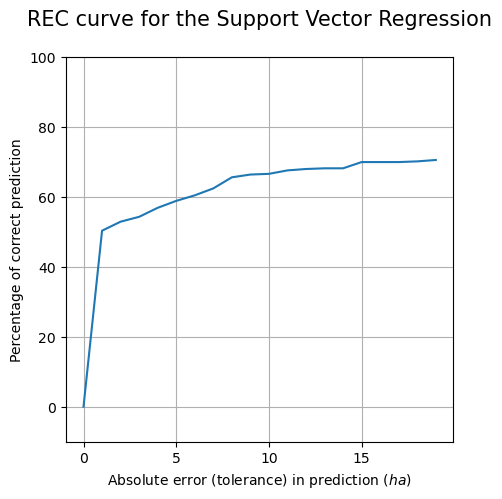

In [175]:
rec_SVR=[]
for i in range(tol_max):
    rec_SVR.append(rec(y_pred,y_test,i))

plt.figure(figsize=(5,5))
plt.title("REC curve for the Support Vector Regression\n",fontsize=15)
plt.xlabel("Absolute error (tolerance) in prediction ($ha$)")
plt.ylabel("Percentage of correct prediction")
plt.xticks([i*5 for i in range(tol_max+1)])
plt.ylim(-10,100)
plt.yticks([i*20 for i in range(6)])
plt.grid(True)
plt.plot(range(tol_max),rec_SVR)